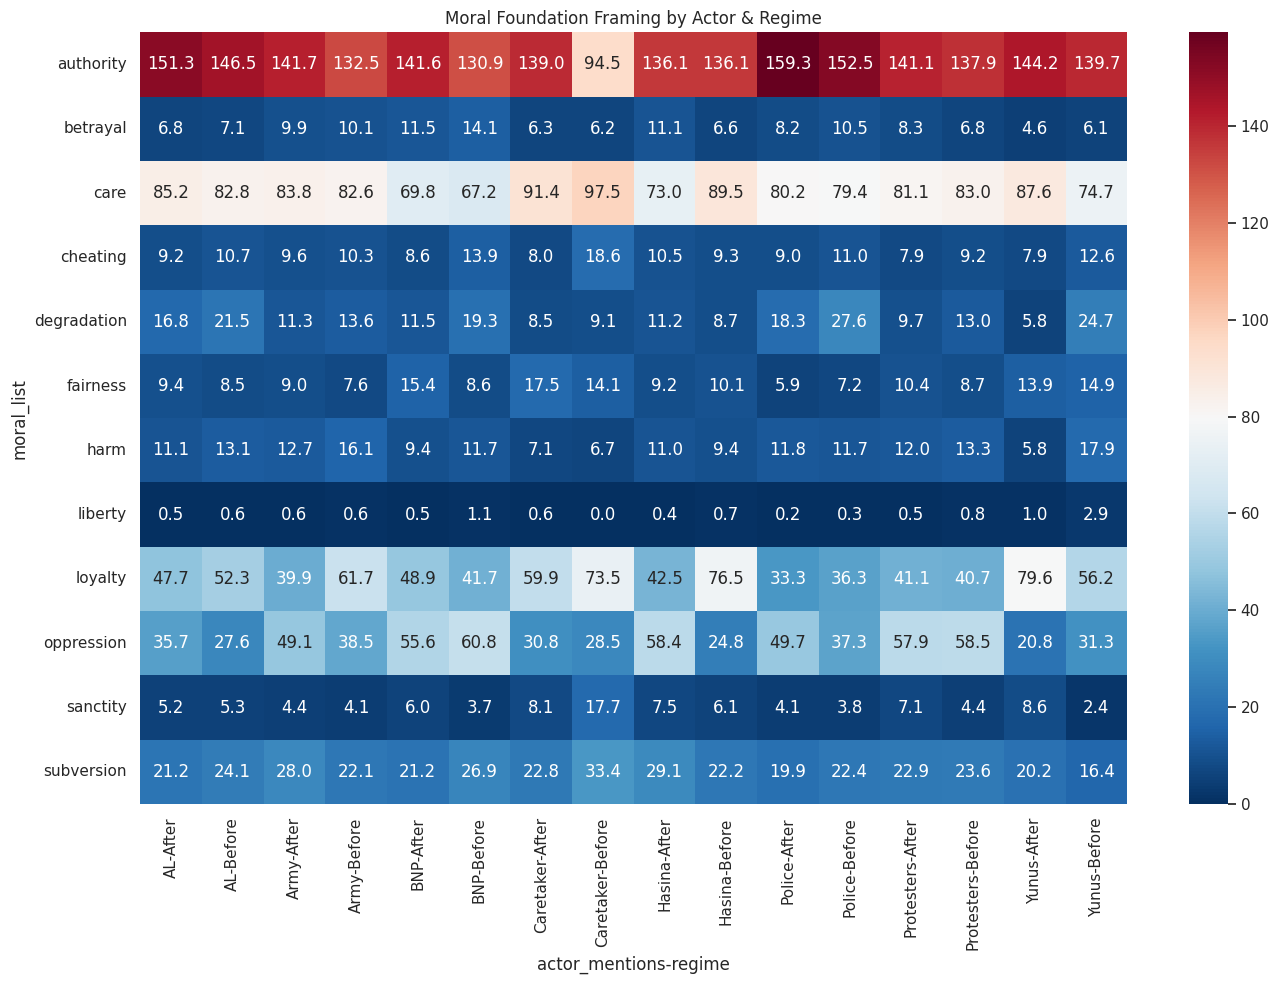

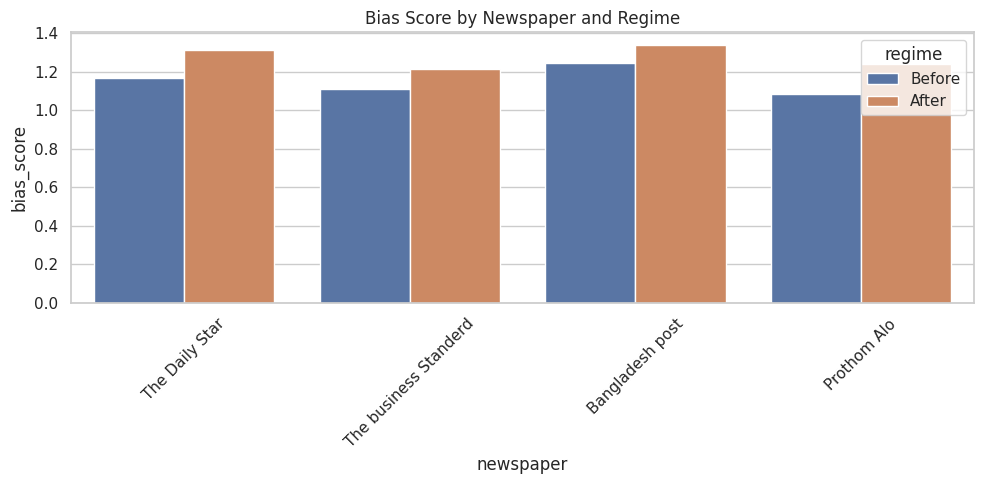

In [ ]:
# 📌 PHASE A-C: Full Bias + Framing + Narrative Shift Analysis
# Author: Best Research-Grade Framing Analysis for Bangladeshi Newspapers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# ------------------------
# STEP 0: LOAD & PREPARE DATA
# ------------------------
df = pd.read_csv("/content/drive/MyDrive/merged_framing_dataset.csv")  # Pre-annotated with sentiment, emotion, moral foundations, etc.
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna(subset=["text", "sentiment", "emotion", "top_2_moral_foundations"])

# Label regime period
df['regime'] = np.where(df['Date'] < '2024-08-05', 'Before', 'After')

# Normalize columns
df['sentiment'] = df['sentiment'].str.lower().str.strip()
df['emotion'] = df['emotion'].str.lower().str.strip()
df['newspaper_name'] = df['newspaper_name'].str.strip()
df['text'] = df['text'].str.lower()

# Parse moral list

def parse_morals(x):
    try:
        parsed = ast.literal_eval(x)
        return [m.strip().lower() for m in parsed if m.strip().lower() != 'none']
    except:
        return []

df['moral_list'] = df['top_2_moral_foundations'].astype(str).apply(parse_morals)
df = df.explode('moral_list')
df = df[df['moral_list'] != '']

# ------------------------
# STEP 1: ACTOR MENTION EXTRACTION
# ------------------------
actor_dict = {
    "Hasina": ["sheikh hasina", "hasina", "prime minister"],
    "Yunus": ["yunus", "dr. yunus", "muhammad yunus"],
    "AL": ["awami league", "al", "ruling party", "chatra league", "bal"],
    "BNP": ["bnp", "khaleda zia", "tarek", "tarek zia", "jamaat", "shibir", "chatradol"],
    "Caretaker": ["caretaker government", "interim government", "neutral govt"],
    "Police": ["police", "law enforcers", "rab", "security forces"],
    "Army": ["army", "military"],
    "Protesters": ["protesters", "activists", "students"]
}

def detect_actors(text):
    found = []
    for label, keywords in actor_dict.items():
        for kw in keywords:
            if kw in text:
                found.append(label)
                break
    return found

df['actor_mentions'] = df['text'].apply(detect_actors)
df = df.explode('actor_mentions')
df = df.dropna(subset=['actor_mentions'])

# ------------------------
# STEP 2: PHASE A — ACTOR FRAMING MATRIX
# ------------------------
grouped = df.groupby([
    'regime', 'actor_mentions', 'newspaper_name', 'moral_list', 'sentiment', 'emotion'
]).size().reset_index(name='count')

# Normalize within actor + newspaper + regime
totals = grouped.groupby(['regime', 'actor_mentions', 'newspaper_name'])['count'].sum().reset_index(name='total')
grouped = grouped.merge(totals, on=['regime', 'actor_mentions', 'newspaper_name'])
grouped['percentage'] = grouped['count'] / grouped['total'] * 100

# Save
grouped.to_csv("/content/actor_bias_matrix.csv", index=False)

# ------------------------
# STEP 3: PHASE B — TOPIC NARRATIVE SHIFT
# ------------------------
# Load BERTopic labels if not already
if 'bertopic_label' not in df.columns:
    bertopic = pd.read_csv("/content/labeled_with_topics.csv")
    df = df.merge(bertopic[['Link', 'bertopic_label']], on='Link', how='left')

# Topic Moral/Emotion Trend
topic_grouped = df.groupby(['regime', 'bertopic_label', 'moral_list', 'emotion']).size().reset_index(name='count')
topic_totals = topic_grouped.groupby(['regime', 'bertopic_label'])['count'].sum().reset_index(name='total')
topic_grouped = topic_grouped.merge(topic_totals, on=['regime', 'bertopic_label'])
topic_grouped['percentage'] = topic_grouped['count'] / topic_grouped['total'] * 100
topic_grouped.to_csv("/content/topic_moral_emotion_shift.csv", index=False)

# ------------------------
# STEP 4: PHASE C — QUANTITATIVE BIAS INDEX
# ------------------------
bias_records = []
for paper in df['newspaper_name'].unique():
    for regime in ['Before', 'After']:
        sub = df[(df['newspaper_name'] == paper) & (df['regime'] == regime)]
        if len(sub) < 50:
            continue

        sent_dist = sub['sentiment'].value_counts(normalize=True)
        emo_dist = sub['emotion'].value_counts(normalize=True)
        moral_dist = sub['moral_list'].value_counts(normalize=True)

        bias_score = (sent_dist.max() - sent_dist.min()) + (emo_dist.max() - emo_dist.min()) + (moral_dist.max() - moral_dist.min())
        bias_records.append({
            'newspaper': paper,
            'regime': regime,
            'bias_score': bias_score,
            'dominant_sentiment': sent_dist.idxmax(),
            'dominant_emotion': emo_dist.idxmax(),
            'dominant_moral': moral_dist.idxmax()
        })

bias_df = pd.DataFrame(bias_records)
bias_df.to_csv("/content/newspaper_bias_index.csv", index=False)

# ------------------------
# STEP 5: VISUALIZATIONS
# ------------------------
sns.set(style="whitegrid")

# Heatmap of actor moral framing
pivot = grouped.pivot_table(index="moral_list", columns=["actor_mentions", "regime"], values="percentage", aggfunc="sum", fill_value=0)
plt.figure(figsize=(14,10))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="RdBu_r")
plt.title("Moral Foundation Framing by Actor & Regime")
plt.tight_layout()
plt.savefig("/content/moral_actor_heatmap.png")

# Plot Bias Score
plt.figure(figsize=(10,5))
sns.barplot(data=bias_df, x="newspaper", y="bias_score", hue="regime")
plt.title("Bias Score by Newspaper and Regime")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("/content/bias_score_plot.png")


In [ ]:
df = pd.read_csv("/content/full_actor_records_cleaned.csv")  # Update with your path
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import ast

# ----------------------------------------
# 📥 1. Load and Prepare Data
# ----------------------------------------
df = pd.read_csv("/content/full_actor_records_cleaned.csv")  # Update with your path
df['Date'] = pd.to_datetime(df['Date'])

# Convert stringified lists to real lists (if needed)
def parse_moral(x):
    try:
        if isinstance(x, str): return [i.strip().lower() for i in ast.literal_eval(x)]
        return x
    except: return []

df["moral_list_clean"] = df["moral_list_clean"].apply(parse_moral)
df = df.explode("moral_list_clean")
df = df.dropna(subset=["moral_list_clean"])

# Define regime boundaries
regime_change_date = pd.to_datetime("2024-08-05")
df["Regime"] = df["Date"].apply(lambda x: "Before" if x < regime_change_date else "After")

# -------------------------------------------------
# 🔍 2. Define Your Target ENTITY for Analysis
# -------------------------------------------------
TARGET_ENTITY = "Sheikh Hasina"  # ← Change this as needed

entity_df = df[df["actor_mentions"] == TARGET_ENTITY]

if entity_df.empty:
    raise ValueError(f"No data found for {TARGET_ENTITY}")

# -------------------------------------------------
# 📊 3. Summary Statistics Before vs After
# -------------------------------------------------
summary = entity_df.groupby(["Regime", "sentiment_label"]).agg({"count": "sum"}).reset_index()
emotion_dist = entity_df.groupby(["Regime", "emotion"]).agg({"count": "sum"}).reset_index()
moral_dist = entity_df.groupby(["Regime", "moral_list_clean"]).agg({"count": "sum"}).reset_index()

# Normalize by total for each regime
total_before = entity_df[entity_df["Regime"] == "Before"]["count"].sum()
total_after = entity_df[entity_df["Regime"] == "After"]["count"].sum()

summary["percentage"] = summary.apply(
    lambda x: x["count"] / total_before * 100 if x["Regime"] == "Before" else x["count"] / total_after * 100,
    axis=1
)

emotion_dist["percentage"] = emotion_dist.apply(
    lambda x: x["count"] / total_before * 100 if x["Regime"] == "Before" else x["count"] / total_after * 100,
    axis=1
)

moral_dist["percentage"] = moral_dist.apply(
    lambda x: x["count"] / total_before * 100 if x["Regime"] == "Before" else x["count"] / total_after * 100,
    axis=1
)

# -------------------------------------------------
# 🧠 4. Visual Comparative Framing
# -------------------------------------------------
def plot_comparison(df, x, y, hue, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df, x=x, y=y, hue=hue)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_comparison(summary, "sentiment_label", "percentage", "Regime", f"Sentiment Framing for {TARGET_ENTITY}")
plot_comparison(emotion_dist, "emotion", "percentage", "Regime", f"Emotion Framing for {TARGET_ENTITY}")
plot_comparison(moral_dist, "moral_list_clean", "percentage", "Regime", f"Moral Framing for {TARGET_ENTITY}")

# -------------------------------------------------
# 🧭 5. Role Estimation via Dominant Framing
# -------------------------------------------------
def get_dominant(df, col):
    counter = Counter(df[col])
    return counter.most_common(3)

dominant_before = entity_df[entity_df["Regime"]=="Before"]
dominant_after = entity_df[entity_df["Regime"]=="After"]

print(f"\n🟥 {TARGET_ENTITY.upper()} BEFORE Regime Change:")
print("→ Top Sentiments:", get_dominant(dominant_before, "sentiment_label"))
print("→ Top Emotions:", get_dominant(dominant_before, "emotion"))
print("→ Top Moral Foundations:", get_dominant(dominant_before, "moral_list_clean"))

print(f"\n🟩 {TARGET_ENTITY.upper()} AFTER Regime Change:")
print("→ Top Sentiments:", get_dominant(dominant_after, "sentiment_label"))
print("→ Top Emotions:", get_dominant(dominant_after, "emotion"))
print("→ Top Moral Foundations:", get_dominant(dominant_after, "moral_list_clean"))

# -------------------------------------------------
# 📰 6. Word Clouds (optional)
# -------------------------------------------------
for regime in ["Before", "After"]:
    subset = entity_df[entity_df["Regime"] == regime]
    phrases = subset["emotion"].dropna().tolist() + subset["moral_list_clean"].dropna().astype(str).tolist()
    text_blob = " ".join(phrases)
    wc = WordCloud(width=800, height=400, background_color="white").generate(text_blob)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"{TARGET_ENTITY} — Common Terms ({regime})")
    plt.show()


ValueError: No data found for Sheikh Hasina

In [ ]:
dx = pd.read_csv("/content/full_actor_records_cleaned.csv")
dx.groupby("actor_mentions").size()

,0
actor_mentions,
Army,5424
Awami League,73228
BNP,5315
Caretaker Government,5658
Dr. Yunus,3758
Jamaat-e-Islami,1492
Jatiya Party,416
Khaleda Zia,1010
Others,12224


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128997 (\N{LARGE RED SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


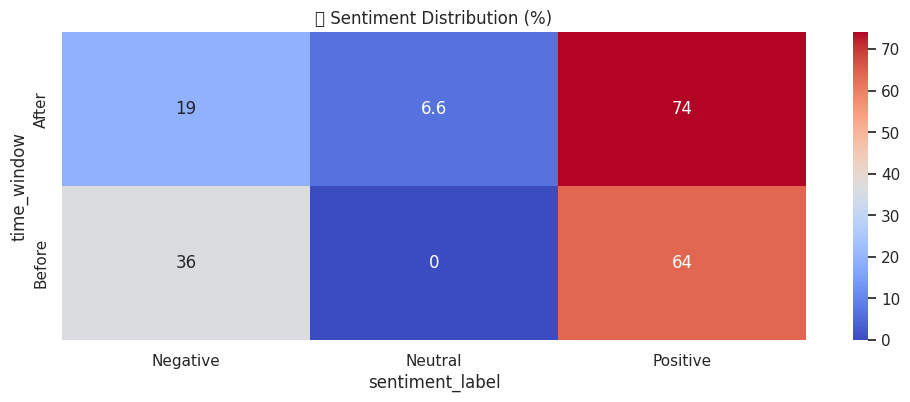

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128162 (\N{ANGER SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


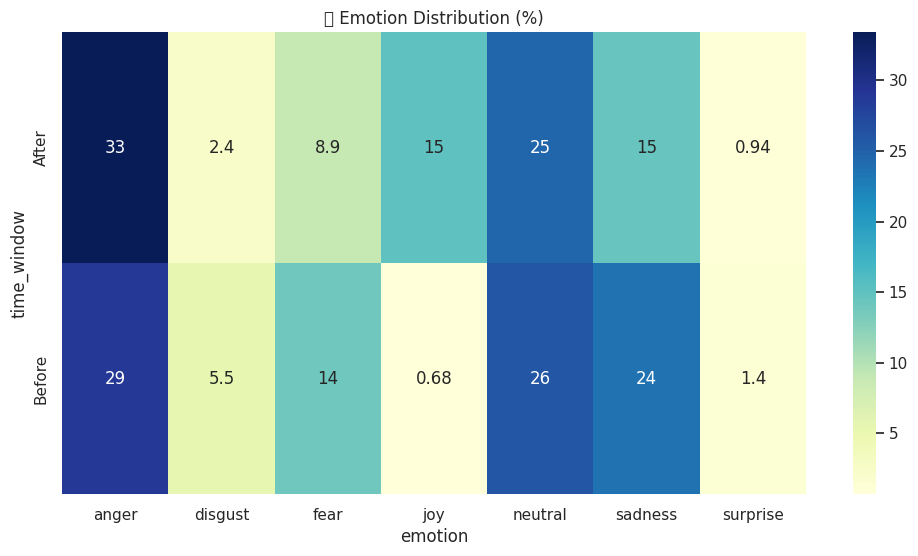

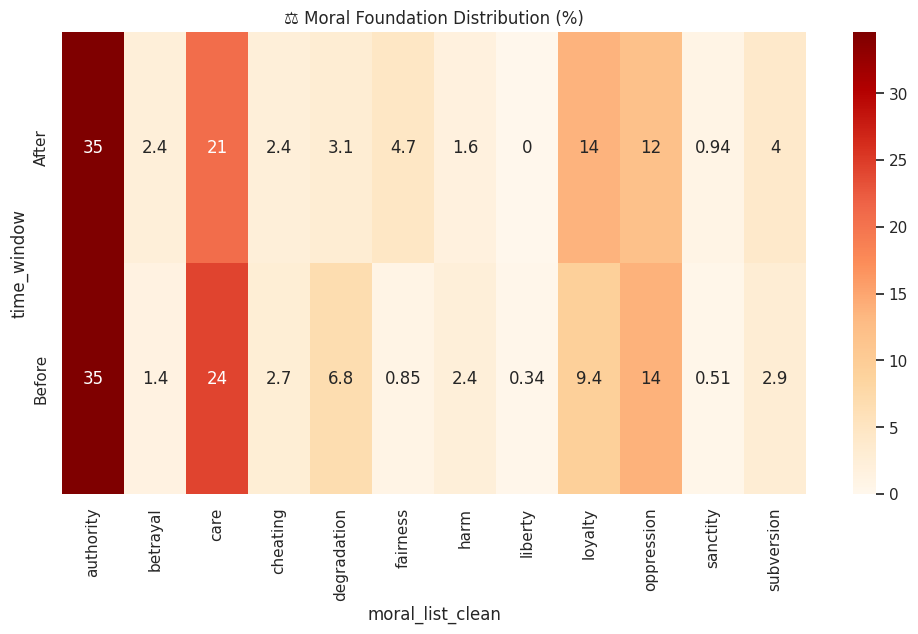

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


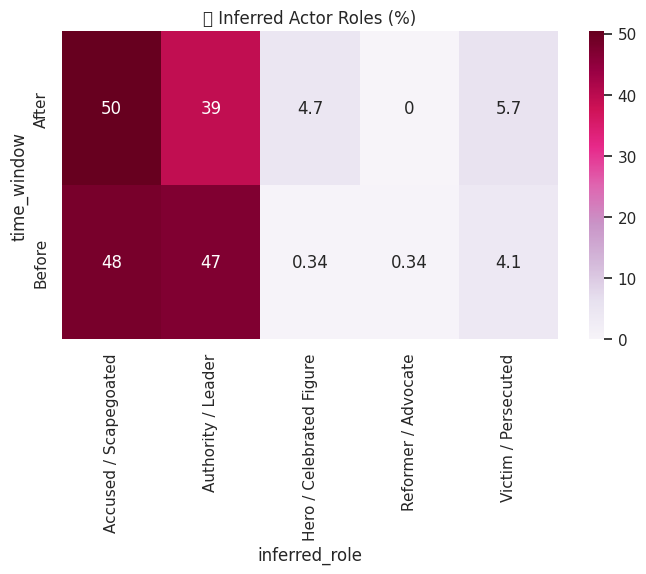

In [ ]:
# 📌 Step 1: Import and Setup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
from wordcloud import WordCloud

# Customize this per your research
ENTITY_NAME = "Khaleda Zia"
START_DATE_BEFORE = "2024-03-01"
END_DATE_BEFORE = "2024-08-04"
START_DATE_AFTER = "2024-08-05"
END_DATE_AFTER = "2024-10-31"

# 📥 Load full dataset (adjust path if needed)
df = pd.read_csv("/content/full_actor_records_cleaned.csv")
df["Date"] = pd.to_datetime(df["Date"])
df["text"] = df["text"].fillna("").str.lower()

# Filter by presence of the entity
df_entity = df[df["actor_mentions"].str.contains(ENTITY_NAME, case=False, na=False)]

# ✅ Assign regime timeframe
df_entity["time_window"] = pd.to_datetime(df_entity["Date"]).apply(
    lambda x: "Before" if START_DATE_BEFORE <= str(x.date()) <= END_DATE_BEFORE else (
              "After" if START_DATE_AFTER <= str(x.date()) <= END_DATE_AFTER else "Outside"))

df_entity = df_entity[df_entity["time_window"].isin(["Before", "After"])]

# ----------------------------
# 📊 Step 2: Frequency Overview
# ----------------------------
def summarize_distribution(col):
    return df_entity.groupby(["time_window", col]).size().unstack(fill_value=0).apply(lambda x: round(100 * x / x.sum(), 2), axis=1)

sentiment_dist = summarize_distribution("sentiment_label")
emotion_dist = summarize_distribution("emotion")
moral_dist = summarize_distribution("moral_list_clean")

# ----------------------------
# 🔍 Step 3: Topic Extraction
# ----------------------------
# Extract top topic words per period from clean_text
from sklearn.feature_extraction.text import CountVectorizer

def extract_keywords(texts, n=1000):
    vec = CountVectorizer(stop_words='english', max_features=1000)
    X = vec.fit_transform(texts)
    keywords = zip(vec.get_feature_names_out(), X.sum(axis=0).A1)
    return sorted(keywords, key=lambda x: -x[1])[:n]

before_keywords = extract_keywords(df_entity[df_entity["time_window"] == "Before"]["clean_text"])
after_keywords = extract_keywords(df_entity[df_entity["time_window"] == "After"]["clean_text"])

# ----------------------------
# 🧭 Step 4: Actor Role Patterns
# ----------------------------
def infer_role(text):
    text = text.lower()

    # 🚨 1. Accused/Scapegoated Frame
    accused_terms = [
        "accused", "charged", "arrested", "jailed", "convicted", "trial", "summoned",
        "allegation", "corruption", "scam", "fraud", "crime", "lawsuit", "grilled",
        "money laundering", "embezzlement", "misappropriation", "illegal"
    ]
    if any(term in text for term in accused_terms):
        return "Accused / Scapegoated"

    # 🛡️ 2. Victim / Persecuted Frame
    victim_terms = [
        "victim", "persecuted", "targeted", "smeared", "witch hunt", "oppressed",
        "unjustly treated", "harassed", "political vendetta", "attack on", "backlash against",
        "intimidated", "silenced", "marginalized", "threatened", "raided"
    ]
    if any(term in text for term in victim_terms):
        return "Victim / Persecuted"

    # 🏅 3. Celebrated / Hero Frame
    hero_terms = [
        "praised", "honoured", "hailed", "admired", "nobel", "icon", "legend", "visionary",
        "revered", "internationally recognized", "awarded", "respected", "celebrated figure"
    ]
    if any(term in text for term in hero_terms):
        return "Hero / Celebrated Figure"

    # 🔧 4. Reformer / Critic / Advocate Frame
    reformer_terms = [
        "criticized", "condemned", "demanded reform", "raised voice", "called out",
        "whistleblower", "challenged the", "campaign against", "advocated for", "exposed",
        "called for change", "highlighted corruption", "spoke against", "urged reform"
    ]
    if any(term in text for term in reformer_terms):
        return "Reformer / Advocate"

    # 👑 5. Authority / Power Figure Frame
    authority_terms = [
        "led", "announced", "decided", "declared", "ordered", "initiated", "oversaw",
        "presided over", "chaired", "managed", "issued statement", "policy", "implemented"
    ]
    if any(term in text for term in authority_terms):
        return "Authority / Leader"

    # 🧩 Default case
    return "Neutral / Unclear"


df_entity["inferred_role"] = df_entity["text"].apply(infer_role)
role_dist = summarize_distribution("inferred_role")

# ----------------------------
# 🧠 Step 5: Visualization
# ----------------------------
plt.figure(figsize=(12, 4))
sns.heatmap(sentiment_dist, annot=True, cmap="coolwarm")
plt.title("🟥 Sentiment Distribution (%)")
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(emotion_dist, annot=True, cmap="YlGnBu")
plt.title("💢 Emotion Distribution (%)")
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(moral_dist, annot=True, cmap="OrRd")
plt.title("⚖️ Moral Foundation Distribution (%)")
plt.show()

plt.figure(figsize=(8, 4))
sns.heatmap(role_dist, annot=True, cmap="PuRd")
plt.title("🧭 Inferred Actor Roles (%)")
plt.show()

# ----------------------------
# 🗣️ Step 6: Narrative Summary
# ----------------------------
def print_keywords(label, keywords):
    print(f"\n🧾 Top Terms ({label} Regime):")
    for word, score in keywords:
        print(f"  - {word} ({score})")

#print_keywords("Before", before_keywords)
#print_keywords("After", after_keywords)

# ----------------------------
# ✍️ Step 7: Export for Reporting
# ----------------------------
sentiment_dist.to_csv(f"/content/{ENTITY_NAME}_sentiment_shift.csv")
emotion_dist.to_csv(f"/content/{ENTITY_NAME}_emotion_shift.csv")
moral_dist.to_csv(f"/content/{ENTITY_NAME}_moral_shift.csv")
role_dist.to_csv(f"/content/{ENTITY_NAME}_role_shift.csv")
df_entity.to_csv(f"/content/{ENTITY_NAME}_full_entity_frame.csv", index=False)
